<a href="https://colab.research.google.com/github/harithadam/learning-pytorch/blob/main/BinaryClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: harithadam
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


In [ ]:
import torch # Torch main framework
import torch.nn as nn # Used for getting the NN Layers
from torch.optim import Adam # Adam Optimizer
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creatning the objects
from torchsummary import summary # Visualize the model layers and number of parameters
from sklearn.model_selection import train_test_split # Split the dataset (train, validation, test)
from sklearn.metrics import accuracy_score # Calculate the testing Accuracy
import matplotlib.pyplot as plt # Plotting the training progress at the end
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations

device = 'cuda' if torch.cuda.is_available() else 'cpu' # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac

In [ ]:
data = pd.read_csv("/content/rice-type-classification/riceClassification.csv")

In [ ]:
data.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
data.isnull().sum()

,0
id,0
Area,0
MajorAxisLength,0
MinorAxisLength,0
Eccentricity,0
ConvexArea,0
EquivDiameter,0
Extent,0
Perimeter,0
Roundness,0


In [ ]:
data.drop(["id"], axis =1, inplace = True)

In [ ]:
print(data.head())
print(data.shape)

   Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0  4537        92.229316        64.012769      0.719916        4677   
1  2872        74.691881        51.400454      0.725553        3015   
2  3048        76.293164        52.043491      0.731211        3132   
3  3073        77.033628        51.928487      0.738639        3157   
4  3693        85.124785        56.374021      0.749282        3802   

   EquivDiameter    Extent  Perimeter  Roundness  AspectRation  Class  
0      76.004525  0.657536    273.085   0.764510      1.440796      1  
1      60.471018  0.713009    208.317   0.831658      1.453137      1  
2      62.296341  0.759153    210.012   0.868434      1.465950      1  
3      62.551300  0.783529    210.657   0.870203      1.483456      1  
4      68.571668  0.769375    230.332   0.874743      1.510000      1  
(18185, 11)


In [ ]:
data['Class'].value_counts(normalize=True)

,proportion
Class,
1,0.549079
0,0.450921


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

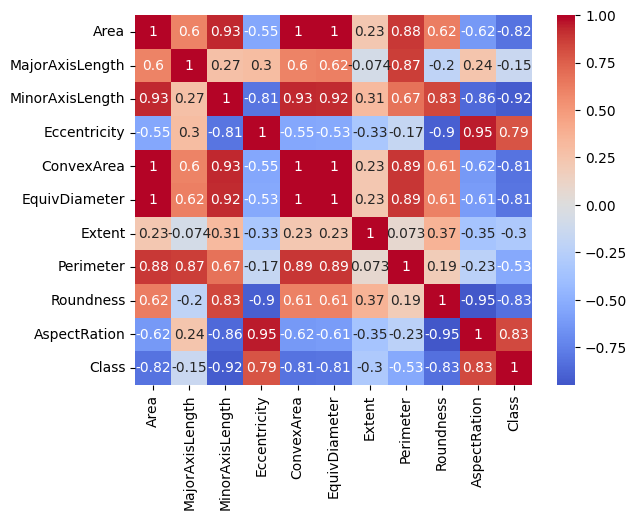

In [ ]:
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

X = data.drop('Class', axis=1)
y = data['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
X_scaled

array([[-1.70363043, -4.80374424,  0.41792669, ..., -2.66177825,
         0.83958835, -2.66379989],
       [-2.83847845, -6.22078914, -0.83561103, ..., -4.85731791,
         1.83721534, -2.6354184 ],
       [-2.71851854, -6.09140363, -0.77169963, ..., -4.79985991,
         2.3835873 , -2.60595002],
       ...,
       [-0.45768318,  0.25018706, -0.6857677 , ..., -0.31708508,
        -0.37389933,  0.75045135],
       [-0.73372729, -0.02285299, -0.82824173, ..., -0.27918653,
        -1.08116545,  0.7868348 ],
       [-0.61513056,  0.11322075, -0.81671191, ..., -0.44047571,
        -0.53075529,  0.84669604]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
class RiceDataset(Dataset):
    def __init__(self, X, y):
        # Convert features and labels to torch tensors
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
# Create Dataset objects
train_dataset = RiceDataset(X_train, y_train)
test_dataset = RiceDataset(X_test, y_test)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
class RiceClassifier(nn.Module):
    def __init__(self, input_size):
        super(RiceClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
model = RiceClassifier(input_size=X.shape[1]).to(device)
summary(model, input_size=(X.shape[1],))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             704
              ReLU-2                   [-1, 64]               0
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                    [-1, 1]              33
           Sigmoid-8                    [-1, 1]               0
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [ ]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 0.1004
Epoch [2/20], Loss: 0.0399
Epoch [3/20], Loss: 0.0388
Epoch [4/20], Loss: 0.0382
Epoch [5/20], Loss: 0.0391
Epoch [6/20], Loss: 0.0362
Epoch [7/20], Loss: 0.0372
Epoch [8/20], Loss: 0.0368
Epoch [9/20], Loss: 0.0357
Epoch [10/20], Loss: 0.0342
Epoch [11/20], Loss: 0.0355
Epoch [12/20], Loss: 0.0359
Epoch [13/20], Loss: 0.0360
Epoch [14/20], Loss: 0.0341
Epoch [15/20], Loss: 0.0343
Epoch [16/20], Loss: 0.0345
Epoch [17/20], Loss: 0.0341
Epoch [18/20], Loss: 0.0343
Epoch [19/20], Loss: 0.0338
Epoch [20/20], Loss: 0.0363


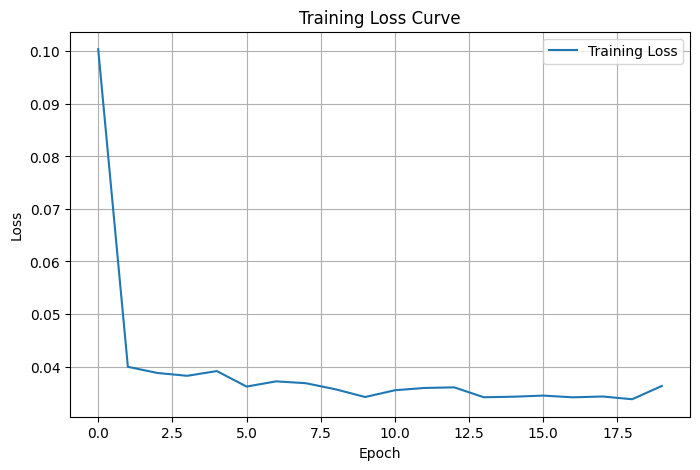

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Convert lists to arrays
all_preds = np.array(all_preds).reshape(-1)
all_labels = np.array(all_labels).reshape(-1)

In [ ]:
print("Test Accuracy:", accuracy_score(all_labels, all_preds))

Test Accuracy: 0.9903232900813723


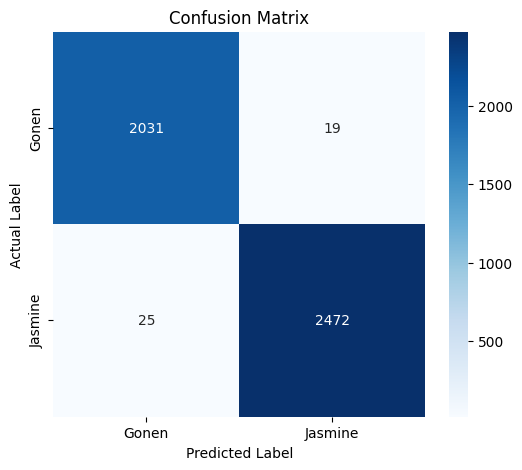

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = ['Gonen', 'Jasmine']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()